<a href="https://colab.research.google.com/github/g-roger/analise-vegetativa-bemagro/blob/main/20ia_05_EDA_bemagro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analise de vegetação

Neste projeto possui dois datasets com imagens de setores de uma fazenda da região do Mato Grosso do Sul. O objetivo é baseado nas mesmas, responder as seguintes questões:

1. Baseado na análise das imagens, podemos avaliar se a lavoura está adiantada ou atrasada?
2. Existem áreas de recorrência do subdesenvolvimento? É possível detectar essas áreas?
3. Existem áreas de subdesenvolvimento exclusivos de uma determinada cultura?

Além dos datasets, foram fornecidos arquivos CSV. Eles listam algumas variáveis sobre as imagens que estão nos datasets.

Os pontos que serão estudados nesse notebook tem como base resolver as questões acima, possivelmente com o uso de ferramentas de visão computacional, machine learning e/ou deep learning.

## Imagens do dataset

As diferenças entre ambos os datasets aparentemente são as localizações. 

As imagens possuem em seu label sua data, podendo realizar uma análise temporal para entender as diferenças e apontar algum estudo que resolva alguma das questões acima.

### Formato das imagens

Ambos os datasets possuem dois diretórios, um chamado RGB e outro NDVI.

RGB é uma escala que possuí três canais(bands) de cores, cujo são: Red, Green e Blue. Comparar as imagens com histogramas nessa escala tende a ser mais efetivo para detectar recorrencia de áreas de subdesenvolvimento.

NDVI é uma imagem que foi cálculada o índice de vegetação, o mesmo é possível análisar a vegetação da localidade e entender melhor sua cultura e monitorar sua lavoura.

A fórmula e como segue:      NDVI = (Infra Vermelho – Vermelho) / (Infra Vermelho +Vermelho)

O princípio teórico é que a vegetação, quanto mais ativa, mais absorve a luz solar na região do vermelho, no processo de trabalho da clorofila nos tecidos vegetais, deixando os valores digitais baixos da imagem de satélite no canal vermelho. Da mesma forma, a estruturas celulares das folhas provocam uma forte reflexão da luz solar na região do  Infravermelho próximo (distribuição angular delas e o fator de reflectância bidirecional e outros fatores externos, explica a literatura), deixando os valores digitais altos da imagem de satélite no canal infra vermelho. (texto retirado de: http://www.engesat.com.br/softwares/global-mapper/calculo-do-indice-de-vegetacao-ndvi-no-global-mapper/#:~:text=NDVI%20%C3%A9%20a%20abrevia%C3%A7%C3%A3o%20da,imagens%20geradas%20por%20sensores%20remotos.)

## Pretenções do projeto

Foram refletidos alguns pontos para resolução das questões:

1. Analise sobre volumetria de culturas;
2. Analise sobre comportamento de variável "Nublado". Entender se a mesma pode interferir nas questões acima;
3. Analise exploratória sobre NDVI para entendimento se lavoura está adiantada ou atrasada;
4. Analise exploratória sobre RGB para entendimento se possuí áreas de subdesenvolvimento (NDVI)
5. Clusterização de grupos de imagens por pixels para saber se estão em área de subdesenvolvimento ou não;
6. Clusterização de grupo de imagens por cultura para entendimento se uma cultura está aparecendo mais em uma área de subdesenvolvimento;
7. Explorar conectar google earth com dados de chuvas/temporais da região listada e saber se tem interferências em áreas de subdesenvolvimento;


Criar novo dataset com porcetagem de produtividade de cada imagem.
Vnet



# Instalações obrigatórias

In [ ]:
# requirements

!pip install rasterio
!pip install ipygee
!pip install geemap

     |████████████████████████████████| 19.3 MB 1.2 MB/s 
     |████████████████████████████████| 3.3 MB 7.6 MB/s 
     |████████████████████████████████| 129 kB 42.6 MB/s 
     |████████████████████████████████| 74 kB 2.6 MB/s 
     |████████████████████████████████| 44 kB 2.0 MB/s 
  Created wheel for ipygee: filename=ipygee-0.0.17-py3-none-any.whl size=40379 sha256=9b2e0644db6892df559a095257276f64a281c44a0e3a978a089da7230d088554
  Stored in directory: /root/.cache/pip/wheels/73/af/7e/a9d3fac7d32e649c63fdbdb9b320181b20eb4bfdc80af13974
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92107 sha256=67db52a3d4b98aa28cd3e444658c25c2d591731c80e9604753c5096f57165957
  Stored in directory: /root/.cache/pip/wheels/5c/55/29/0a09dcf6b39bba8c890e40171cac3e3607a5c4b354b7e9447c
Successfully built ipygee geetools
     |████████████████████████████████| 2.0 MB 6.5 MB/s 
     |████████████████████████████████| 1.7 MB 34.2 MB/s 
     |████████████████████████████████| 130 k

# Importações

In [ ]:
# imports
import ee
import geemap

import pandas as pd
import rasterio
from rasterio.plot import show, show_hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import rasterio.features
import rasterio.warp
from ipygee import*
rasterio.__version__

'1.2.10'

# Leitura de datasets

In [ ]:
# paths

path = 'https://raw.githubusercontent.com/g-roger/analise-vegetativa-bemagro/main/datasets'
dataset_1 = path + '/dataset_1/'
dataset_2 = path + '/dataset_2/'
df_1 = pd.read_csv(dataset_1 + 'DATASET1.csv')
df_2 = pd.read_csv(dataset_2 + 'DATASET2.csv')

In [ ]:
# Lista com todos os arquivos raster do dataset

def get_rasters(df, dataset):
  raster_list = []
  for file in df['NDVI']:
    try:
      raster_list.append(dataset + file)
    except:
      print('ops, não achei', file)
      continue
  return raster_list

rasters_df1 = get_rasters(df_1, dataset_1)
rasters_df2 = get_rasters(df_2, dataset_2)

In [ ]:
df_1.sort_values(by='Nublado', ascending=False)

,temp ano,temp mes,Data,Nublado,Cultura,RGB,NDVI
7,2017,1,2017-01-04,"9,52%",colheita,RGB/2017-01-04.tif,NDVI/2017-01-04.tif
16,2017,11,2017-11-15,"6,93%",soja,RGB/2017-11-15.tif,NDVI/2017-11-15.tif
29,2018,12,2018-12-25,"6,34%",colheita,RGB/2018-12-25.tif,NDVI/2018-12-25.tif
44,2020,3,2020-03-19,"6,04%",algodao,RGB/2020-03-19.tif,NDVI/2020-03-19.tif
9,2017,4,2017-04-04,"56,00%",algodao,RGB/2017-04-04.tif,NDVI/2017-04-04.tif
...,...,...,...,...,...,...,...
21,2018,4,2018-04-14,"0,00%",algodao,RGB/2018-04-14.tif,NDVI/2018-04-14.tif
22,2018,5,2018-05-14,"0,00%",algodao,RGB/2018-05-14.tif,NDVI/2018-05-14.tif
23,2018,6,2018-06-18,"0,00%",algodao,RGB/2018-06-18.tif,NDVI/2018-06-18.tif
34,2019,5,2019-05-19,"0,00%",algodao,RGB/2019-05-19.tif,NDVI/2019-05-19.tif


In [ ]:
df_1.head(20)

,temp ano,temp mes,Data,Nublado,Cultura,RGB,NDVI
0,2016,3,2016-03-30,"0,00%",algodao,RGB/2016-03-30.tif,NDVI/2016-03-30.tif
1,2016,4,2016-04-29,"0,00%",algodao,RGB/2016-04-29.tif,NDVI/2016-04-29.tif
2,2016,7,2016-07-18,"0,00%",algodao,RGB/2016-07-18.tif,NDVI/2016-07-18.tif
3,2016,8,2016-08-07,"0,00%",colheita,RGB/2016-08-07.tif,NDVI/2016-08-07.tif
4,2016,9,2016-09-16,"0,89%",soja,RGB/2016-09-16.tif,NDVI/2016-09-16.tif
5,2016,11,2016-11-25,"13,24%",soja,RGB/2016-11-25.tif,NDVI/2016-11-25.tif
6,2016,12,2016-12-05,"22,73%",soja,RGB/2016-12-05.tif,NDVI/2016-12-05.tif
7,2017,1,2017-01-04,"9,52%",colheita,RGB/2017-01-04.tif,NDVI/2017-01-04.tif
8,2017,2,2017-02-23,"13,08%",algodao,RGB/2017-02-23.tif,NDVI/2017-02-23.tif
9,2017,4,2017-04-04,"56,00%",algodao,RGB/2017-04-04.tif,NDVI/2017-04-04.tif


In [ ]:
df_2

,temp ano,temp mes,Data,Nublado,Cultura,RGB,NDVI
0,2016,3,2016-03-30,"0,00%",algodao,RGB/2016-03-30.tif,NDVI/2016-03-30.tif
1,2016,4,2016-04-29,"0,00%",algodao,RGB/2016-04-29.tif,NDVI/2016-04-29.tif
2,2016,5,2016-05-19,"0,00%",algodao,RGB/2016-05-19.tif,NDVI/2016-05-19.tif
3,2016,6,2016-06-28,"0,00%",algodao,RGB/2016-06-28.tif,NDVI/2016-06-28.tif
4,2016,7,2016-07-18,"0,00%",colheita,RGB/2016-07-18.tif,NDVI/2016-07-18.tif
...,...,...,...,...,...,...,...
62,2021,8,2021-08-11,"0,00%",algodao,RGB/2021-08-11.tif,NDVI/2021-08-11.tif
63,2021,9,2021-09-15,"0,00%",colheita,RGB/2021-09-15.tif,NDVI/2021-09-15.tif
64,2021,10,2021-10-15,"0,00%",soja,RGB/2021-10-15.tif,NDVI/2021-10-15.tif
65,2021,11,2021-11-29,"0,00%",soja,RGB/2021-11-29.tif,NDVI/2021-11-29.tif


In [ ]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   temp ano  66 non-null     int64 
 1   temp mes  66 non-null     int64 
 2   Data      66 non-null     object
 3   Nublado   66 non-null     object
 4   Cultura   66 non-null     object
 5   RGB       66 non-null     object
 6   NDVI      66 non-null     object
dtypes: int64(2), object(5)
memory usage: 3.7+ KB


# 1. Analise sobre volumetria de culturas

In [ ]:
# contagem de imagens de cada uma das culturas:

print(df_1.Cultura.value_counts(),'\n')
print(df_2.Cultura.value_counts())

algodao     34
soja        21
colheita    11
Name: Cultura, dtype: int64 

algodao     35
soja        21
colheita    11
Name: Cultura, dtype: int64


In [ ]:
df_1_culturas = df_1.groupby('Cultura').size().reset_index().sort_values(0, ascending=False)
df_2_culturas = df_2.groupby('Cultura').size().reset_index().sort_values(0, ascending=False)
df_1_culturas.head()

,Cultura,0
0,algodao,34
2,soja,21
1,colheita,11


In [ ]:
df_2_culturas

,Cultura,0
0,algodao,35
2,soja,21
1,colheita,11


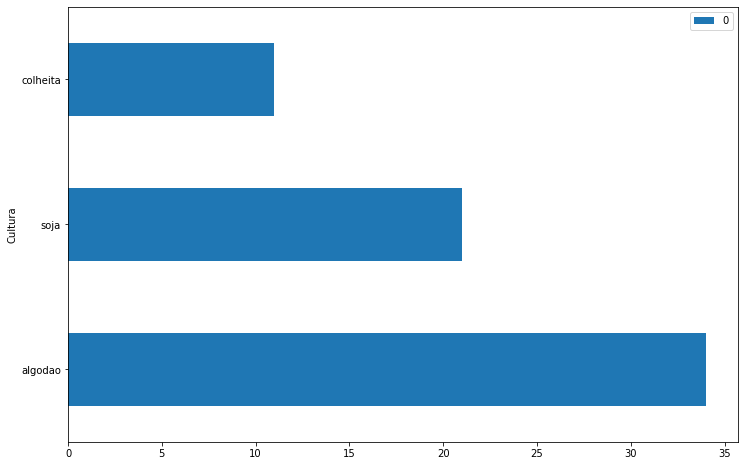

In [ ]:
df_1_culturas.plot.barh(x='Cultura', y=0, figsize=(12,8))

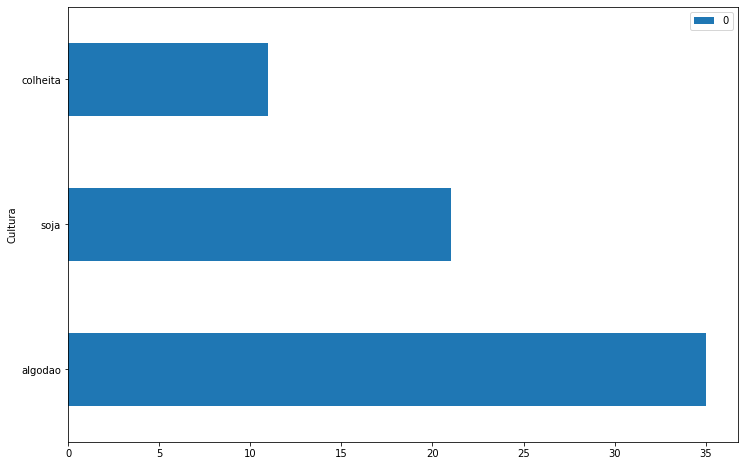

In [ ]:
df_2_culturas.plot.barh(x='Cultura', y=0, figsize=(12,8))

- Ambos os datasets possuem aproximadamente a mesma quantidade de culturas;
- Levando em consideração que cada uma das imagens tem seu tempo, o tempo a quantidade de plantação de algodão é maior enquanto soja é menor. A colheita é representada 11 vezes em ambos datasets;

for # Analise exploratória sobre NDVI para entendimento se lavoura está adiantada ou atrasada

In [ ]:
df_1.head(11)

,temp ano,temp mes,Data,Nublado,Cultura,RGB,NDVI
0,2016,3,2016-03-30,"0,00%",algodao,RGB/2016-03-30.tif,NDVI/2016-03-30.tif
1,2016,4,2016-04-29,"0,00%",algodao,RGB/2016-04-29.tif,NDVI/2016-04-29.tif
2,2016,7,2016-07-18,"0,00%",algodao,RGB/2016-07-18.tif,NDVI/2016-07-18.tif
3,2016,8,2016-08-07,"0,00%",colheita,RGB/2016-08-07.tif,NDVI/2016-08-07.tif
4,2016,9,2016-09-16,"0,89%",soja,RGB/2016-09-16.tif,NDVI/2016-09-16.tif
5,2016,11,2016-11-25,"13,24%",soja,RGB/2016-11-25.tif,NDVI/2016-11-25.tif
6,2016,12,2016-12-05,"22,73%",soja,RGB/2016-12-05.tif,NDVI/2016-12-05.tif
7,2017,1,2017-01-04,"9,52%",colheita,RGB/2017-01-04.tif,NDVI/2017-01-04.tif
8,2017,2,2017-02-23,"13,08%",algodao,RGB/2017-02-23.tif,NDVI/2017-02-23.tif
9,2017,4,2017-04-04,"56,00%",algodao,RGB/2017-04-04.tif,NDVI/2017-04-04.tif


In [ ]:
# definindo mapa de cores de índice

mymap = mpl.colors.LinearSegmentedColormap.from_list('mycolors',['red','green'])

sm = plt.cm.ScalarMappable(cmap=mymap)


In [ ]:
ndvi_images = []

for i in range(0, 7):
  ndvi_images.append(rasterio.open(dataset_1 + df_1['NDVI'][i]))

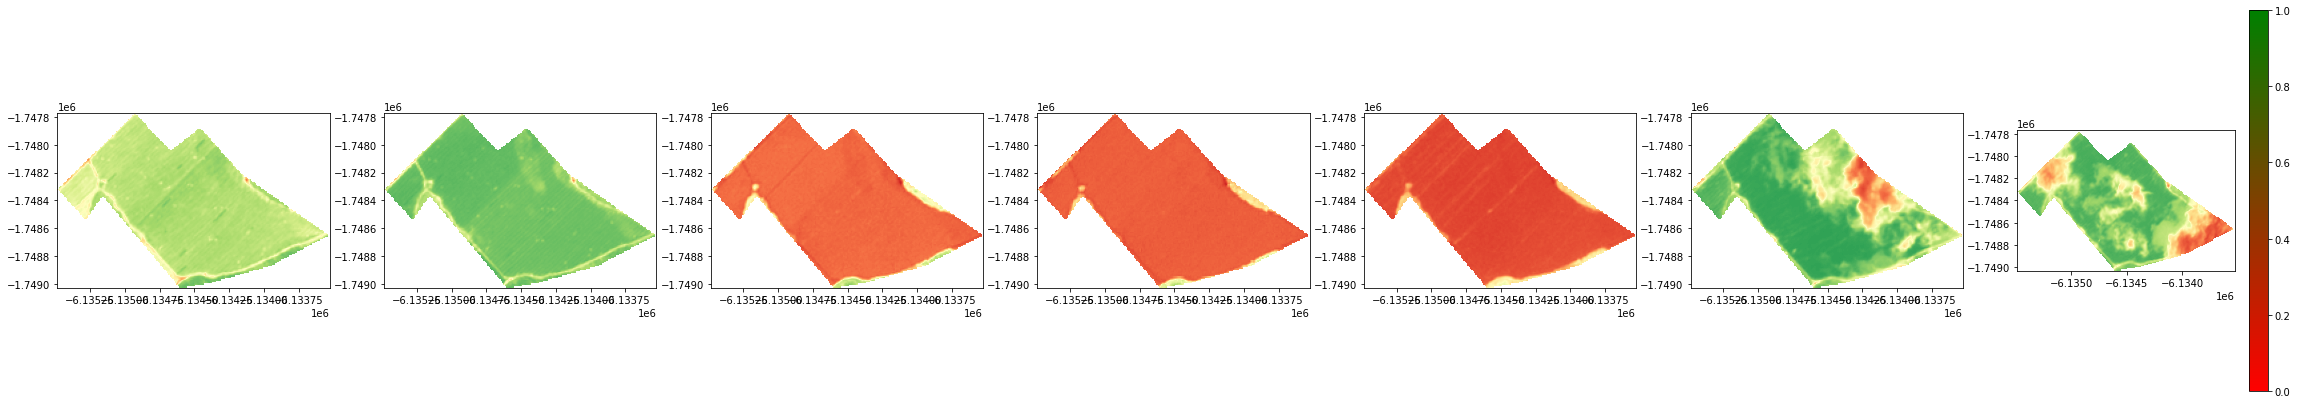

In [ ]:

fig, axes = plt.subplots(1, len(ndvi_images), figsize=(40,7))
for ax, ndvi in zip(axes.flat, ndvi_images):
    show(ndvi, ax=ax, cmap='RdYlGn', vmin=0, vmax=1)

plt.colorbar(sm)
plt.show()

- Observamos que quanto mais vermelha a imagem, mais próxima da colheita.. é um ponto sobre a lavoura estar adiantada?

- será que é caracteristica da cultura "soja" demorar a imagem ficar vermelha. Ou é um indício de atraso da lavoura


In [ ]:
df_1.head(7)

,temp ano,temp mes,Data,Nublado,Cultura,RGB,NDVI
0,2016,3,2016-03-30,"0,00%",algodao,RGB/2016-03-30.tif,NDVI/2016-03-30.tif
1,2016,4,2016-04-29,"0,00%",algodao,RGB/2016-04-29.tif,NDVI/2016-04-29.tif
2,2016,7,2016-07-18,"0,00%",algodao,RGB/2016-07-18.tif,NDVI/2016-07-18.tif
3,2016,8,2016-08-07,"0,00%",colheita,RGB/2016-08-07.tif,NDVI/2016-08-07.tif
4,2016,9,2016-09-16,"0,89%",soja,RGB/2016-09-16.tif,NDVI/2016-09-16.tif
5,2016,11,2016-11-25,"13,24%",soja,RGB/2016-11-25.tif,NDVI/2016-11-25.tif
6,2016,12,2016-12-05,"22,73%",soja,RGB/2016-12-05.tif,NDVI/2016-12-05.tif


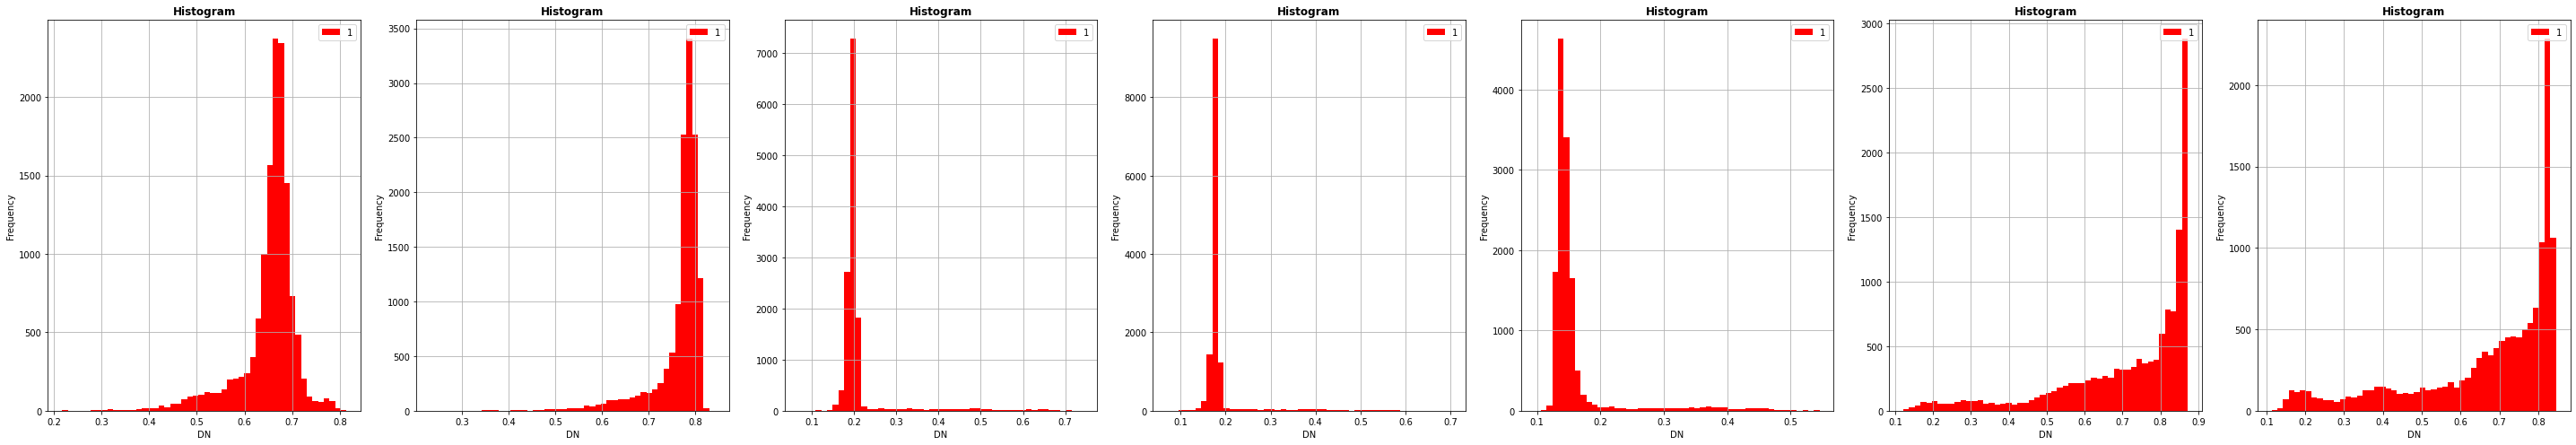

In [ ]:

fig, axes = plt.subplots(1, len(ndvi_images), figsize=(40,7))
for ax, ndvi in zip(axes.flat, ndvi_images):
  show_hist(ndvi, ax=ax, bins=50, stacked=False, histtype='stepfilled', title="Histogram")

fig.tight_layout()

# Analise exploratória sobre RGB para entendimento se possuí áreas de subdesenvolvimento

In [ ]:
rgb_images = []

for i in range(0, 7):
  rgb_images.append(rasterio.open(dataset_1 + df_1['RGB'][i]))

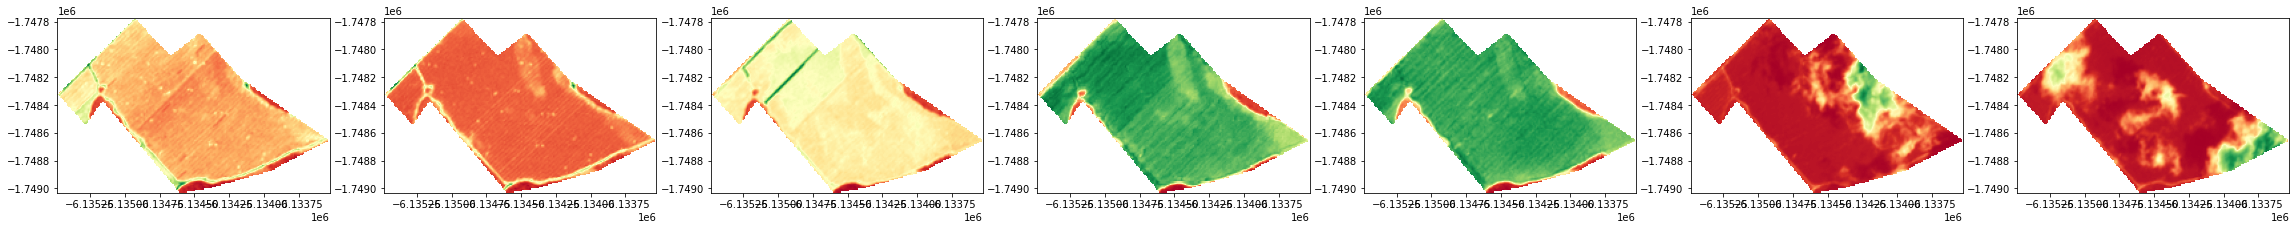

In [ ]:

fig, axes = plt.subplots(1, len(rgb_images), figsize=(40,7))
for ax, rgb in zip(axes.flat, rgb_images):
    show(rgb, ax=ax, cmap='RdYlGn')

plt.show()

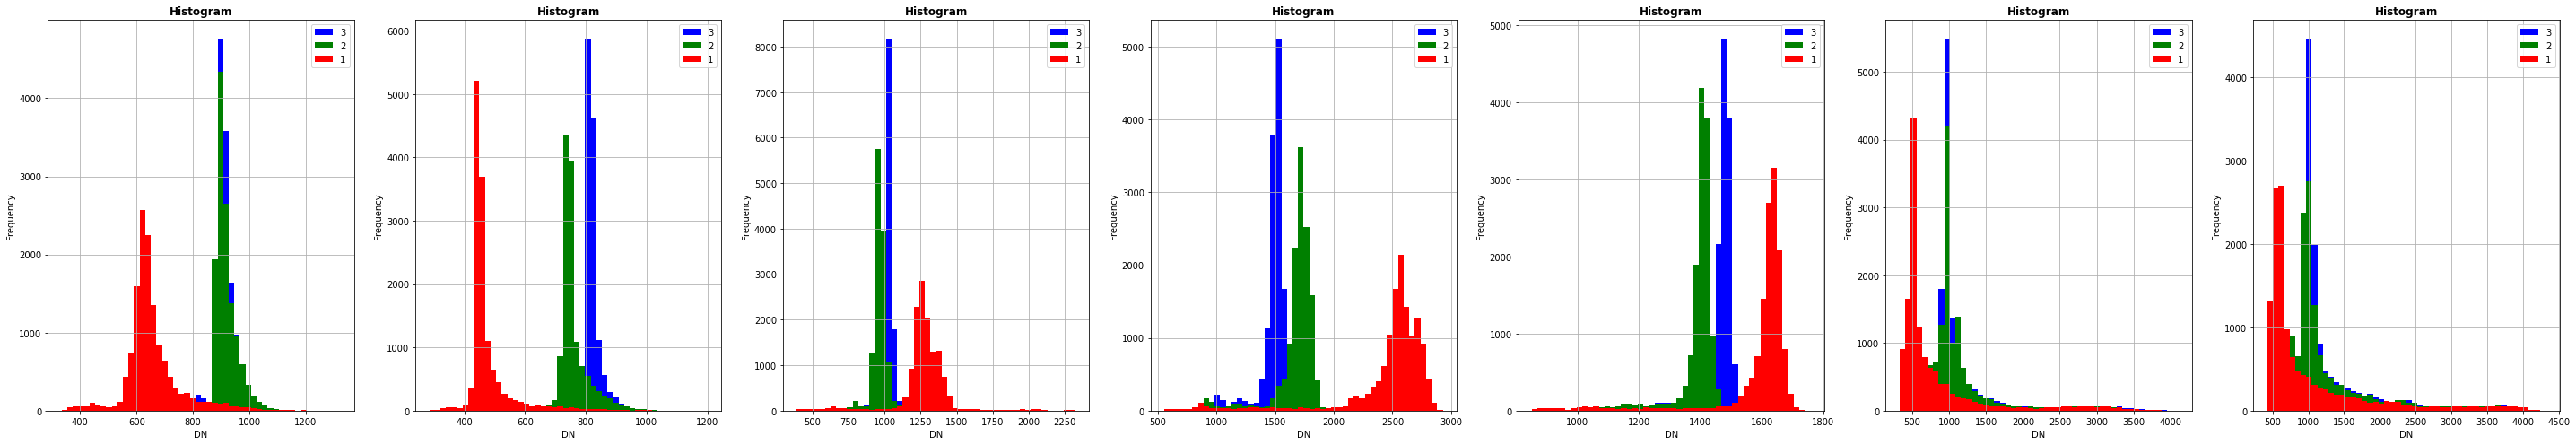

In [ ]:

fig, axes = plt.subplots(1, len(rgb_images), figsize=(40,7))
for ax, rgb in zip(axes.flat, rgb_images):
  show_hist(rgb, ax=ax, bins=50, stacked=False, histtype='stepfilled', title="Histogram")

fig.tight_layout()

In [ ]:
# estudos e testes

In [ ]:
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=OW3OQ4EjUhJG-gJxpsIQqD4VjVheFHm9TyBnXCSS0uo&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjDyuJg_GFlgd0qId4RWawdsT-YGDsz0gvLzSsxJpGdvvcvmJSTc_E

Successfully saved authorization token.


In [ ]:
modis = ee.ImageCollection(rasters_df1)

modis

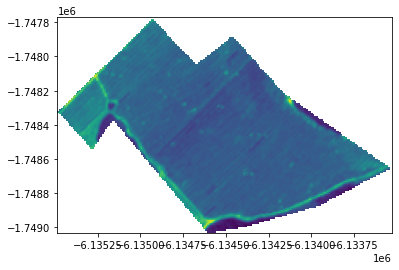

In [ ]:
img_1_rgb = rasterio.open(dataset_1 + df_1['RGB'][0])
show(img_1_rgb)

In [ ]:
img_band_1 = img_1_rgb.read(1)
img_band_2 = img_1_rgb.read(2)
img_band_3 = img_1_rgb.read(3)

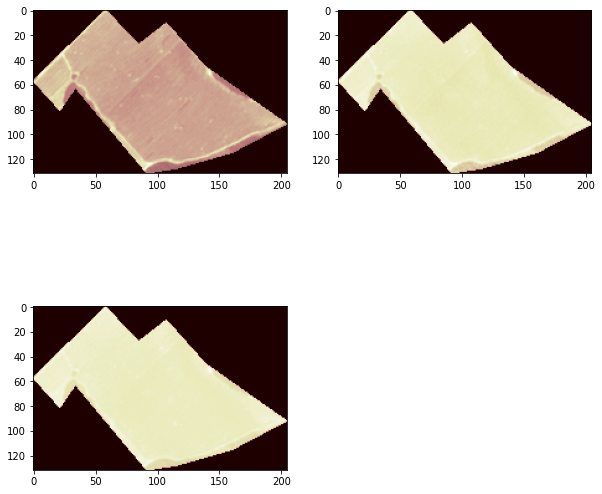

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(img_band_1, cmap='pink')
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(img_band_2, cmap='pink')
ax3 = fig.add_subplot(2,2,3)
ax3.imshow(img_band_3, cmap='pink')

In [ ]:
 img_1_rgb.count

3

In [ ]:
# coordenadas 
img_1_rgb.crs

CRS.from_epsg(3857)

In [ ]:
img_1_rgb.descriptions

(None, None, None)

In [ ]:
# encontrar geotransform
img_1_rgb.transform

Affine(9.554628535647032, 0.0, -6135485.60490867,
       0.0, -9.554628535647032, -1747770.8702546984)

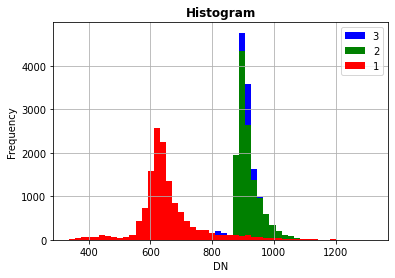

In [ ]:
rasterio.plot.show_hist(img_1_rgb, bins=50, histtype='stepfilled', lw=0.0, stacked=False)

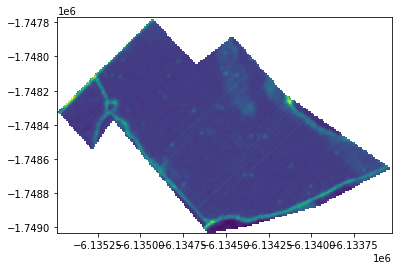

In [ ]:
img_2_rgb = rasterio.open(dataset_1 + df_1['RGB'][1])
show(img_2_rgb)

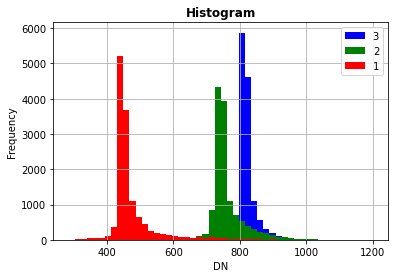

In [ ]:
rasterio.plot.show_hist(img_2_rgb, bins=50, histtype='stepfilled', lw=0.0, stacked=False)

In [ ]:
img_1_rgb.bounds

BoundingBox(left=-6135485.60490867, bottom=-1749032.0812214038, right=-6133526.906058863, top=-1747770.8702546984)

# Insumo para estudo (SEGMENTAÇÃO DE SUPERPIXELS)

Através da exploração das colorações dos NDVIS e seus histogramas, chegamos a um consenso de segmentar os setores das imagens e classifica-los de algumas forma

# Segmentação de imagens para construção de novo dataset

O objetivo da seção abaixo é criar segmentação entre as imagens e assim definir o que é cada setor e baseado no mesmo, vamos inserir uma informação no dataset com o percentual de produtividade baseado na cor.

Algumas tecnicas serão utilizadas através de alguns algoritmos como Slic que utiliza Kmeans e Quickshift que tambem se baseia em aproximação de kernel;


## QuickShift

Quickshift is a relatively recent 2D image segmentation algorithm, based on an approximation of kernelized mean-shift. Therefore it belongs to the family of local mode-seeking algorithms and is applied to the 5D space consisting of color information and image location 2.

One of the benefits of quickshift is that it actually computes a hierarchical segmentation on multiple scales simultaneously.

Quickshift has two main parameters: sigma controls the scale of the local density approximation, max_dist selects a level in the hierarchical segmentation that is produced. There is also a trade-off between distance in color-space and distance in image-space, given by ratio.

2 Quick shift and kernel methods for mode seeking, Vedaldi, A. and Soatto, S. European Conference on Computer Vision, 2008


## Slic

This algorithm simply performs K-means in the 5d space of color information and image location and is therefore closely related to quickshift. As the clustering method is simpler, it is very efficient. It is essential for this algorithm to work in Lab color space to obtain good results. The algorithm quickly gained momentum and is now widely used. See 3 for details. The compactness parameter trades off color-similarity and proximity, as in the case of Quickshift, while n_segments chooses the number of centers for kmeans.





Para as seguintes experimentações estamos utilizando a lib skimage ao invés de rasterio

In [ ]:
from skimage.segmentation import quickshift, slic
from skimage import io
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from skimage.color import rgb2gray

In [ ]:
img = io.imread(dataset_1 + df_1['RGB'][0])
img.shape

(132, 205, 3)

In [ ]:
img_n = io.imread(dataset_1 + df_1['NDVI'][0])
img_n

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       ...,
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]],
      dtype=float32)

In [ ]:
img.ndim

3

In [ ]:
segments_quickshift = quickshift(img)
print("Quickshift número de segmentos: %d" % len(np.unique(segments_quickshift)))

Quickshift número de segmentos: 21


https://www.youtube.com/watch?v=uDhcpwxCufU

In [186]:
segments_slic = slic(img, n_segments=20, compactness=0.9, sigma=0.2,
                     start_label=1)
print("Slic número de segmentos: %d" % len(np.unique(segments_slic)))
print("Size: ", segments_slic.size)

Slic número de segmentos: 23
Size:  27060


In [ ]:
gradient = sobel(rgb2gray(img))
print("Gradient número de segmentos: %d" % len(np.unique(gradient)))

Gradient número de segmentos: 14143


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Gradient')

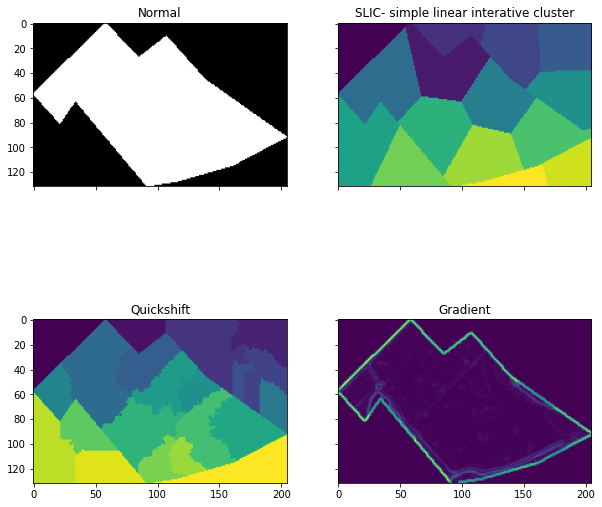

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
ax[0, 0].imshow(img)
ax[0, 0].set_title("Normal")
ax[0, 1].imshow(segments_slic)
ax[0, 1].set_title('SLIC- simple linear interative cluster')
ax[1, 0].imshow(segments_quickshift)
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(gradient)
ax[1, 1].set_title('Gradient')

Observando os resultados obtidos, vamos seguir com a segmentação SLIC.

obs:

Testamos o mesmo com imagens NDVI, porém a divisão dos segmentos ficou melhor para se trabalhar com RGB

Até este momento utilizamos o site https://scikit-image.org/ para insumo dos estudos

In [187]:
segments_slic.data

In [277]:
from skimage.measure import regionprops, regionprops_table, moments
from matplotlib.lines import Line2D


In [218]:
# Acessando cada um dos segmentos
# https://scikit-image.org/docs/dev/api/skimage.measure.html

props = pd.DataFrame(regionprops_table(segments_slic, img))
props

,label,bbox-0,bbox-1,bbox-2,bbox-3
0,1,0,0,50,58
1,2,0,31,46,81
2,3,0,59,28,109
3,4,0,108,39,146
4,5,0,145,30,178
5,6,0,174,37,205
6,7,11,75,66,125
7,8,27,133,65,176
8,9,28,0,82,45
9,10,31,107,76,161


In [263]:
# moments
props_df = pd.DataFrame(regionprops_table(segments_slic, img, properties=['label', 'centroid', 'orientation', 'bbox', 'coords', 'solidity']))

In [264]:
props_df

,label,centroid-0,centroid-1,orientation,bbox-0,bbox-1,bbox-2,bbox-3,coords,solidity
0,1,18.001815,19.387175,-0.856863,0,0,50,58,"[[0, 0], [0, 1], [0, 2], [0, 3], [0, 4], [0, 5...",0.993389
1,2,26.206560,56.672715,-1.361952,0,31,46,81,"[[0, 58], [1, 57], [1, 58], [1, 59], [2, 56], ...",0.978825
2,3,9.347561,86.000000,1.518537,0,59,28,109,"[[0, 59], [0, 60], [0, 61], [0, 62], [0, 63], ...",0.979689
3,4,14.646318,128.739341,0.804793,0,108,39,146,"[[0, 109], [0, 110], [0, 111], [0, 112], [0, 1...",0.981922
4,5,13.263699,160.601598,1.531261,0,145,30,178,"[[0, 145], [0, 146], [0, 147], [0, 148], [0, 1...",0.971175
5,6,17.515181,190.205681,-0.051760,0,174,37,205,"[[0, 178], [0, 179], [0, 180], [0, 181], [0, 1...",0.976099
6,7,38.697281,99.383082,-0.625682,11,75,66,125,"[[11, 107], [12, 105], [12, 106], [12, 107], [...",0.929775
7,8,41.824974,156.480041,1.127361,27,133,65,176,"[[27, 145], [27, 146], [27, 147], [27, 148], [...",0.967327
8,9,54.269612,23.447068,-0.671566,28,0,82,45,"[[28, 30], [29, 28], [29, 29], [29, 30], [30, ...",0.875333
9,10,56.579079,132.564017,1.090141,31,107,76,161,"[[31, 125], [32, 124], [32, 125], [32, 126], [...",0.927795


In [226]:
moments(segments_slic, order=3)

array([[3.14063000e+05, 3.30379210e+07, 4.55698021e+09, 7.02708277e+11],
       [2.68432910e+07, 2.75349832e+09, 3.75857008e+11, 5.76314738e+13],
       [2.63274871e+09, 2.67825620e+11, 3.64613147e+13, 5.58412678e+15],
       [2.75996103e+11, 2.79730131e+13, 3.80542202e+15, 5.82752630e+17]])

In [266]:
segments_slic_ids = np.unique(segments_slic)
segments_slic_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])

In [267]:
centers = np.array([np.mean(np.nonzero(segments_slic==i),axis=1) for i in segments_slic_ids])


In [299]:
vs_right = np.vstack([segments_slic[:,:-1].ravel(), segments_slic[:,1:].ravel()])
vs_below = np.vstack([segments_slic[:-1,:].ravel(), segments_slic[1:,:].ravel()])
bneighbors = np.unique(np.hstack([vs_right, vs_below]), axis=1)

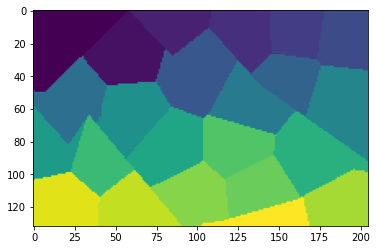

In [300]:
plt.imshow(segments_slic)

# Classificação de pixels

In [301]:
colors = ['purple','blue','green','yellowgreen']

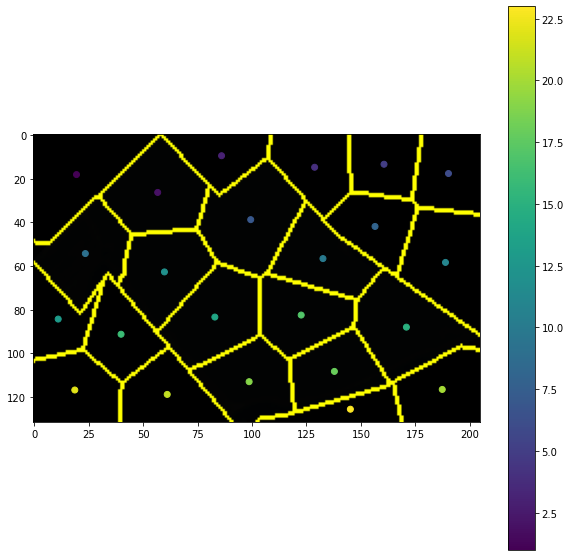

In [311]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(mark_boundaries(img, segments_slic))
plt.scatter(centers[:,1],centers[:,0], c=segments_slic_ids)

cb = plt.colorbar()


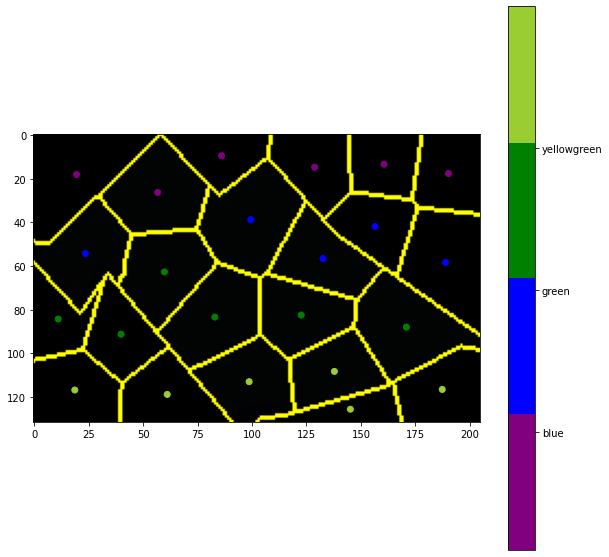

In [308]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(mark_boundaries(img, segments_slic))
plt.scatter(centers[:,1],centers[:,0], c=segments_slic_ids, cmap=mpl.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(segments_slic_ids),max(segments_slic_ids)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

IndexError: ignored

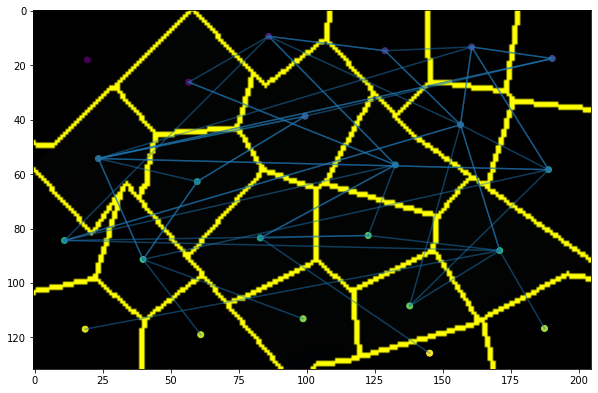

In [312]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.imshow(mark_boundaries(img, segments_slic))
plt.scatter(centers[:,1],centers[:,0], c=segments_slic_ids)


for i in range(bneighbors.shape[1]):
    y0,x0 = centers[bneighbors[0,i]]
    y1,x1 = centers[bneighbors[1,i]]

    l = Line2D([x0,x1],[y0,y1], alpha=0.5)
    ax.add_line(l)